# Introduction

This Jupyter Notebook is about Data Mining for Credit Card Fraud. The goal of the task in this notebook is to detect fraud in credit card transactions. The problem is quite challenging because the number of fraudulent transactions is very small compared with the non-fraudulent transactions. A classifier that classifies all transactions as non-fraudulent will obtain a great accuracy score, but won't achieve the goal of the task.

We will follow Cross-industry Standard Process for Data Mining or [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) in this notebook, which is a standard process that is [commonly used](https://www.forbes.com/sites/metabrown/2015/07/29/what-it-needs-to-know-about-the-data-mining-process) for data mining. Although there are six major phases according to this standard process, not all phases will be explored. Furthermore, the sequence of the phases is not strict because moving back and forth between different phases is usually required.

# Setup

First, we need to import several libraries that will be used in this notebook. After that, we need to specify the location of the dataset and the images that will be generated.

In [1]:
# Import library
import os
import warnings
import pandas as pd

import function.visualization as vis
import function.imbalance as imb
import function.classification as cls
import function.derivation as drv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from subprocess import check_call

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Set directory
input_file = "dataset/data_for_student_case.csv"
figure_directory = "figure/"
dot_file = figure_directory + "tree.dot"
figure_white_box = figure_directory + "tree.png"

# Create figure directory
if not os.path.exists(figure_directory):
    print('Creating directory for figures...')
    os.makedirs(figure_directory)

# Data Understanding

Data understanding phase covers all activities that enable us to become familiar with the data, discover initial insights, and identify issues in the data. There are a few generic tasks that are typically done in this phase: initial data collection, data description, data exploration, and data verification.

First, load the data and check some of the very first rows in the data. 

In [3]:
# Load input data
dataset = pd.read_csv(input_file)

In [4]:
# Show sample records
dataset.head()

txid          bookingdate issuercountrycode txvariantcode       bin  \
0     1  2015-11-09 14:26:51                MX      mccredit  530056.0   
1     2  2015-11-09 14:27:38                MX      mccredit  547046.0   
2     3  2015-11-23 16:34:16                MX      mccredit  528843.0   
3     4  2015-11-23 16:34:51                MX      mccredit  547146.0   
4     5  2015-11-09 14:26:08                MX   visaclassic  477291.0   

     amount currencycode shoppercountrycode shopperinteraction simple_journal  \
0   64800.0          MXN                 MX          Ecommerce     Chargeback   
1   44900.0          MXN                 MX          Ecommerce     Chargeback   
2  149900.0          MXN                 MX          Ecommerce     Chargeback   
3  109900.0          MXN                 MX          Ecommerce     Chargeback   
4   89900.0          MXN                 MX          Ecommerce     Chargeback   

  cardverificationcodesupplied  cvcresponsecode         creationdate  \
0                         True                0  2015-07-01 23:03:11   
1                         True                0  2015-07-02 04:50:55   
2                         True                0  2015-07-02 14:30:28   
3                         True                0  2015-07-03 07:53:37   
4                         True                0  2015-07-08 18:35:35   

     accountcode      mail_id     ip_id     card_id  
0  MexicoAccount   email68370  ip111778  card184798  
1  MexicoAccount  email101299   ip78749  card151595  
2  MexicoAccount  email278604   ip70594  card242142  
3  MexicoAccount   email47409  ip113648  card181744  
4  MexicoAccount  email205501   ip83553   card97271

Next, examine the data and then describe the data that we have in terms of the format, the quantity, and the variables available in the data. After that, assess the quality of the data.

In [5]:
# Show more information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null object
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null object
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null object
card_id  

In [6]:
# Show the statistical description of the data
dataset.describe()

txid            bin        amount  cvcresponsecode
count  290382.000000  290242.000000  2.903820e+05    290382.000000
mean   279916.750673  485254.586238  2.936462e+04         0.769004
std    138437.214796   37015.528140  6.829927e+04         0.508933
min         1.000000  400000.000000  5.000000e+01         0.000000
25%    218232.250000  462239.000000  4.400000e+03         0.000000
50%    304071.500000  475139.000000  7.095000e+03         1.000000
75%    387592.750000  518652.000000  1.589500e+04         1.000000
max    482734.000000  676883.000000  2.785840e+06         5.000000

In [7]:
# Show the statistical description of the data
dataset.describe(include=['object'])

bookingdate issuercountrycode txvariantcode currencycode  \
count                290382            289889        290382       290382   
unique                92951               136            15            5   
top     2015-10-06 22:24:34                GB     visadebit          GBP   
freq                     59            200560        172592       207413   

       shoppercountrycode shopperinteraction simple_journal  \
count              289900             290382         290382   
unique                153                  3              3   
top                    GB          Ecommerce        Settled   
freq               199438             282155         236691   

       cardverificationcodesupplied         creationdate accountcode  \
count                        275665               290382      290382   
unique                            2               284023           4   
top                            True  2015-08-22 10:12:01   UKAccount   
freq                         267428                    7      207413   

            mail_id    ip_id     card_id  
count        290382   290382      290382  
unique       220952   220441      234814  
top     email170659  ip17828  card210128  
freq            436      505         443

In [8]:
# Count the number of records that have any null value
dataset.loc[pd.isnull(dataset).any(axis=1)].shape[0]

15815

In [9]:
# Check the number of records of each class
total_records = dataset.shape[0]
for label in dataset.simple_journal.unique().tolist():
    count = dataset.loc[dataset['simple_journal']==label].shape[0]
    proportion = round(count/total_records*100, 2)
    print(count, ' (', proportion, '%)\t', label, sep="")

345 (0.12%)	Chargeback
53346 (18.37%)	Refused
236691 (81.51%)	Settled


Here we can see that there are 290,382 records and 17 variables in the data. There are numerical and categorical variables, and 15,815 records have missing values. "Simple_journal" is a variable that informs us whether a transaction is fraudulent (Chargeback) or not (Refused and Settled).

We can also see that the proportion of non-fraudulent transactions is very large: 99.88% of the total records. A classifier that classifies all records as non-fraudulent transactions will gain 99.88% accuracy score. However, this is not what we want since the goal is to detect fraudulent transactions.

# Data Preparation

Garbage in, garbage out. Data preparation phase covers all activities required to form the final data that will be used in the next phase. A few typical generic tasks in this phase are data selection, data cleaning, and data transformation.

Here we will clean the data by removing records with missing values, select records that are labeled as "Chargeback" (fraudulent) and "Settled" (non-fraudulent), and format the data.

In [10]:
# Clean and filter the data
dataset = dataset.dropna()
dataset = dataset[dataset.simple_journal != 'Refused']

In [11]:
# Change the format of some variables

# Convert to datetime
for column in ['bookingdate', 'creationdate']:
    dataset[column] = pd.to_datetime(
        dataset.bookingdate, 
        format='%Y-%m-%d %H:%M:%S', 
        errors='coerce'
    )

# Convert to category
for column in [
    'issuercountrycode',
    'txvariantcode',
    'currencycode',
    'shoppercountrycode',
    'cardverificationcodesupplied',
    'shopperinteraction',
    'cvcresponsecode',
    'accountcode'
]:
    dataset[column] = dataset[column].astype('category')

In [12]:
# Check the result
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223510 entries, 0 to 290381
Data columns (total 17 columns):
txid                            223510 non-null int64
bookingdate                     223510 non-null datetime64[ns]
issuercountrycode               223510 non-null category
txvariantcode                   223510 non-null category
bin                             223510 non-null float64
amount                          223510 non-null float64
currencycode                    223510 non-null category
shoppercountrycode              223510 non-null category
shopperinteraction              223510 non-null category
simple_journal                  223510 non-null object
cardverificationcodesupplied    223510 non-null category
cvcresponsecode                 223510 non-null category
creationdate                    223510 non-null datetime64[ns]
accountcode                     223510 non-null category
mail_id                         223510 non-null object
ip_id                          

# Visualization Task

After data preparation, we will go back to the data understanding phase and explore the data by using some visualizations. We will use data visualization to discover interesting patterns and create an initial hypothesis.

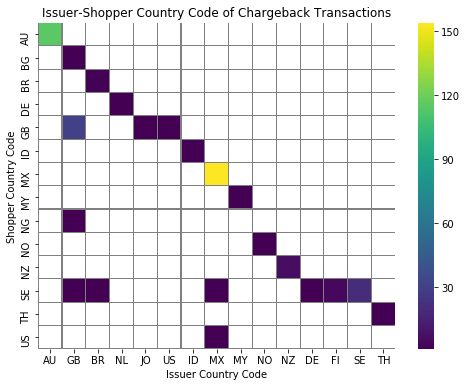

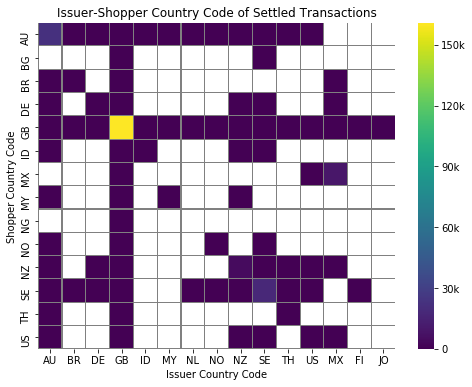

In [13]:
# Visualize the data using heat map
vis.heatmap(
    dataset=dataset, 
    label='Chargeback', 
    title='Issuer-Shopper Country Code of Chargeback Transactions',
    filename=figure_directory + 'heatmap_chargeback.png'
)
vis.heatmap(
    dataset=dataset, 
    label='Settled', 
    title='Issuer-Shopper Country Code of Settled Transactions',
    filename=figure_directory + 'heatmap_settled.png'
)

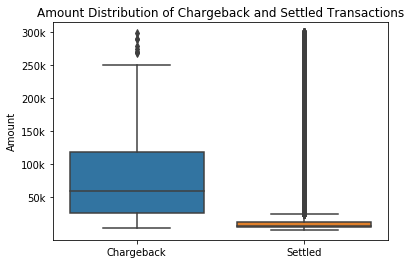

In [14]:
# Visualize the data using box plot
vis.boxplot(
    dataset=dataset, 
    title='Amount Distribution of Chargeback and Settled Transactions',
    filename=figure_directory + 'boxplot_amount.png'
)

From the figures above, we can see that most of the fraudulent transactions happened in Mexico and Australia. It is also found that the median amount of fraudulent transactions is higher than non-fraudulent transactions. From these findings, we can conclude that these two variables can be used to distinguish the fraudulent and non-fraudulent transactions.

# Imbalance Task

As mentioned before, there is an imbalance between the number of fraudulent transactions and non-fraudulent transactions. Therefore, instead of accuracy, we will use other metrics to evaluate the performance of the classifiers, which are [true positive rate](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) and [false positive rate](https://en.wikipedia.org/wiki/Sensitivity_and_specificity). One option that can be used to handle the imbalance issue is by using [Synthetic Minority Over-sampling Technique (SMOTE)](https://jair.org/index.php/jair/article/view/10302). By using this technique, we can change the distribution of the data by creating artificial data.

Here we will use six variables in the data as input variables and create classifiers using logistic regression and multilayer perceptron. The data will be divided into training and test set, where the distribution of the data in the training set is modified by using SMOTE. We will evaluate the impact of SMOTE by using [ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which depict the true positive rate and false positive rate of the classifiers.

In [15]:
# Data preparation
subset = dataset[[
    'txvariantcode',
    'amount',
    'currencycode',
    'shopperinteraction',
    'cardverificationcodesupplied',
    'cvcresponsecode',
    'simple_journal'
]]

subset.loc[subset.simple_journal == 'Chargeback', 'simple_journal'] = 1
subset.loc[subset.simple_journal == 'Settled', 'simple_journal'] = 0
subset['simple_journal'] = subset['simple_journal'].astype('int')

In [16]:
# Determine the label and input features
y = subset.simple_journal

x = subset.drop('simple_journal', axis=1)
x = pd.get_dummies(x)

In [17]:
# Split training and test set
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.5,
    random_state=42, 
    stratify=y
)

In [18]:
# Perform oversampling using SMOTE
oversampling = SMOTE(ratio=float(0.5), random_state=42)
x_smoted, y_smoted = oversampling.fit_sample(x_train, y_train)

In [19]:
# Normalize the input variables (only based on training data distribution)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_smoted = scaler.transform(x_smoted)

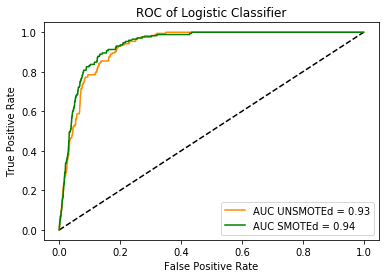

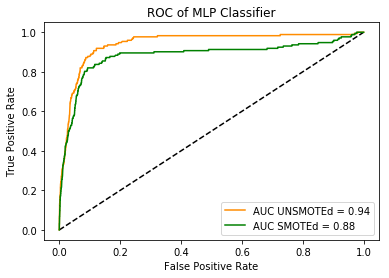

In [20]:
# Generate ROC curves with different classifiers
imb.compare_roc(
    algorithm=LogisticRegression(),
    title='ROC of Logistic Classifier',
    filename=figure_directory + 'roc_logistic.png',
    feature_train=x_train,
    feature_test=x_test,
    feature_resampled=x_smoted,
    label_train=y_train,
    label_test=y_test,
    label_resampled=y_smoted
)

imb.compare_roc(
    algorithm=MLPClassifier(),
    title='ROC of MLP Classifier',
    filename=figure_directory + 'roc_mlp.png',
    feature_train=x_train,
    feature_test=x_test,
    feature_resampled=x_smoted,
    label_train=y_train,
    label_test=y_test,
    label_resampled=y_smoted
)

It is desired that all fraudulent transactions are identified without having false classifications of fraudulent transactions. It means that the best curve should reach the upper left corner or having 1.0 AUC score. However, from the figures above, it can be seen that SMOTE only improves the performance of the classifier trained with logistic regression. It improves the AUC from 0.93 to 0.94.

# Classification Task

There are two types of classifiers that can be used for classification problems: white-box and black-box classifiers. With white-box classifiers, we can explain why certain classifications are made. However, sometimes the performance of this type of classifier is not that good. In contrast, it is hard to explain why certain classifications are made with black-box classifiers. However, sometimes the performance of black-box classifiers is better compared with white-box classifiers.

Here we will use similar methods as [Bhattacharyya et al.](https://www.sciencedirect.com/science/article/pii/S0167923610001326), which are logistic regression and random forests, to create white-box and black-box  classifiers respectively. In addition, we also use decision tree to create the white-box classifier due to its simplicity and ease of use. Another advantage of decision tree is the capability to visualize the decision rule that is generated after the training process. Unlike in the previous task, we will evaluate the performance of classifiers using [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) method. We will also perform [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) to improve the performance of classifiers.

## White-box classifier

In [21]:
# Using Logistic Regression
list_ratio = [None, 0.1, 0.2, 0.5]
tuning_result = []

# Tuning the classifier
for ratio in list_ratio:
    
    print('Evaluate ratio =', ratio)
    tp, fp, tn, fn, auc = cls.cross_validation(
        method=LogisticRegression(),
        x=x,
        y=y,
        number_of_fold=10,
        smote_ratio=ratio
    )
    evaluation_result = cls.evaluate_result(tp, fp, tn, fn)
    tuning_result.append([ratio] + evaluation_result)

# Show the result
tuning_result = pd.DataFrame(
    tuning_result, 
    columns =[
        'SMOTE Ratio', 
        'TP',
        'FP',
        'TN',
        'FN',
        'Accuracy',
        'Precision',
        'Recall',
        'FPR',
        'F1'
    ]
)
tuning_result.head()

Evaluate ratio = None
Evaluate ratio = 0.1
Evaluate ratio = 0.2
Evaluate ratio = 0.5


SMOTE Ratio    TP      FP       TN    FN  Accuracy  Precision    Recall  \
0          NaN   0.0     0.1  22316.4  34.5  0.998452        NaN  0.000000   
1          0.1  10.0   440.3  21876.2  24.5  0.979205   0.022135  0.284847   
2          0.2  18.6   971.2  21345.3  15.9  0.955836   0.018868  0.532458   
3          0.5  29.4  2915.3  19401.2   5.1  0.869339   0.009975  0.856423   

        FPR        F1  
0  0.000004       NaN  
1  0.019730  0.041078  
2  0.043519  0.036444  
3  0.130634  0.019721

In [22]:
# Find out important variables with Logistic Regression

# Perform oversampling using SMOTE
oversampling = SMOTE(ratio=float(0.1), random_state=42)
x_smoted, y_smoted = oversampling.fit_sample(x_train, y_train)

# Train the classifier
classifier = LogisticRegression()
classifier.fit(x_smoted, y_smoted)

# Get coefficient of the input variables
variable_coefficient = zip(classifier.coef_[0], x.columns)
variable_coefficient = [list(ele) for ele in variable_coefficient]

# Sort based on the absolute value
variable_coefficient.sort(key=lambda item: abs(item[0]), reverse=True)

# Show coefficient of the input variables 
for item in variable_coefficient:
    print(round(item[0], 2), '\t', item[1])

-1.13 	 cvcresponsecode_1
-0.88 	 currencycode_GBP
-0.68 	 txvariantcode_visadebit
-0.6 	 shopperinteraction_Ecommerce
-0.6 	 cardverificationcodesupplied_True
0.49 	 cvcresponsecode_0
-0.28 	 currencycode_SEK
0.28 	 currencycode_MXN
0.27 	 currencycode_AUD
-0.16 	 txvariantcode_mcdebit
0.09 	 txvariantcode_visaclassic
0.06 	 txvariantcode_visagold
-0.05 	 cardverificationcodesupplied_False
0.04 	 txvariantcode_visasignature
-0.04 	 shopperinteraction_ContAuth
-0.03 	 currencycode_NZD
0.02 	 txvariantcode_visabusiness
-0.02 	 txvariantcode_visaplatinum
0.02 	 txvariantcode_visapurchasing
-0.01 	 shopperinteraction_POS
-0.01 	 txvariantcode_visa
-0.01 	 txvariantcode_visacorporate
-0.01 	 txvariantcode_mccredit
-0.0 	 cvcresponsecode_3
-0.0 	 txvariantcode_electron
-0.0 	 cvcresponsecode_5
-0.0 	 cvcresponsecode_2
0.0 	 amount


In [23]:
# Using Decision Tree
list_ratio = [None, 0.1, 0.2, 0.5]
list_depth = [3, 5]
tuning_result = []

# Tuning the classifier
for ratio in list_ratio:
    for depth in list_depth:    
        print('Evaluate ratio =', ratio, 'and max depth =', depth)
        tp, fp, tn, fn, auc = cls.cross_validation(
            method=DecisionTreeClassifier(max_depth=depth),
            x=x,
            y=y,
            number_of_fold=10,
            smote_ratio=ratio
        )
        evaluation_result = cls.evaluate_result(tp, fp, tn, fn)
        tuning_result.append([ratio, depth] + evaluation_result)

# Show the result
tuning_result = pd.DataFrame(
    tuning_result, 
    columns =[
        'SMOTE Ratio',
        'Max Depth',
        'TP',
        'FP',
        'TN',
        'FN',
        'Accuracy',
        'Precision',
        'Recall',
        'FPR',
        'F1'
    ]
)
tuning_result.head(8)

Evaluate ratio = None and max depth = 3
Evaluate ratio = None and max depth = 5
Evaluate ratio = 0.1 and max depth = 3
Evaluate ratio = 0.1 and max depth = 5
Evaluate ratio = 0.2 and max depth = 3
Evaluate ratio = 0.2 and max depth = 5
Evaluate ratio = 0.5 and max depth = 3
Evaluate ratio = 0.5 and max depth = 5


SMOTE Ratio  Max Depth    TP      FP       TN    FN  Accuracy  Precision  \
0          NaN          3   0.0     0.2  22316.3  34.5  0.998447        NaN   
1          NaN          5   0.0     1.0  22315.5  34.5  0.998412        NaN   
2          0.1          3   9.2   276.6  22039.9  25.3  0.986493   0.032085   
3          0.1          5  12.0   333.3  21983.2  22.5  0.984081   0.035148   
4          0.2          3  24.7  1250.4  21066.1   9.8  0.943618   0.019432   
5          0.2          5  21.1   871.1  21445.4  13.4  0.960427   0.024173   
6          0.5          3  23.6  1255.0  21061.5  10.9  0.943363   0.018748   
7          0.5          5  22.0  1126.4  21190.1  12.5  0.949045   0.019222   

     Recall       FPR        F1  
0  0.000000  0.000009       NaN  
1  0.000000  0.000045       NaN  
2  0.275034  0.012394  0.057467  
3  0.351407  0.014935  0.063905  
4  0.713248  0.056030  0.037833  
5  0.612537  0.039034  0.046511  
6  0.678902  0.056238  0.036488  
7  0.634888  0.050474  0.037315

In [24]:
# Visualize the Decision Tree classifier

# Perform oversampling using SMOTE
oversampling = SMOTE(ratio=float(0.1), random_state=42)
x_smoted, y_smoted = oversampling.fit_sample(x_train, y_train)

# Train the classifier
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(x_smoted, y_smoted)

# Export the tree
export_graphviz(
    classifier, 
    out_file=dot_file, 
    feature_names = x.columns,
    class_names=['normal', 'fraud'],
    rounded=True,
    precision=2,
    filled=True
)

# Convert to png format
!dot -Tpng figure/tree.dot -o figure/tree.png -Gdpi=600

# Visualize
from IPython.display import Image
Image(filename = 'figure/tree.png')

## Black-box classifier

In [25]:
# Using Random Forest
list_ratio = [None, 0.1, 0.2, 0.5]
list_depth = [3, 5, 10]
list_estimator = [10, 20, 50]
tuning_result = []

# Tuning the classifier
for ratio in list_ratio:
    for depth in list_depth:
        for estimator in list_estimator:
            print(
                'Evaluate ratio =', ratio, 
                'and max depth =', depth,
                'and number of estimators =', estimator
            )
            tp, fp, tn, fn, auc = cls.cross_validation(
                method=RandomForestClassifier(
                    max_depth=depth, 
                    n_estimators=estimator
                ),
                x=x,
                y=y,
                number_of_fold=10,
                smote_ratio=ratio
            )
            evaluation_result = cls.evaluate_result(tp, fp, tn, fn)
            tuning_result.append([ratio, depth, estimator] + evaluation_result)

# Show the result
tuning_result = pd.DataFrame(
    tuning_result, 
    columns =[
        'SMOTE Ratio',
        'Max Depth',
        'Number Estimators',
        'TP',
        'FP',
        'TN',
        'FN',
        'Accuracy',
        'Precision',
        'Recall',
        'FPR',
        'F1'
    ]
)
tuning_result.head(36)

Evaluate ratio = None and max depth = 3 and number of estimators = 10
Evaluate ratio = None and max depth = 3 and number of estimators = 20
Evaluate ratio = None and max depth = 3 and number of estimators = 50
Evaluate ratio = None and max depth = 5 and number of estimators = 10
Evaluate ratio = None and max depth = 5 and number of estimators = 20
Evaluate ratio = None and max depth = 5 and number of estimators = 50
Evaluate ratio = None and max depth = 10 and number of estimators = 10
Evaluate ratio = None and max depth = 10 and number of estimators = 20
Evaluate ratio = None and max depth = 10 and number of estimators = 50
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 10
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 20
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 50
Evaluate ratio = 0.1 and max depth = 5 and number of estimators = 10
Evaluate ratio = 0.1 and max depth = 5 and number of estimators = 20
Evaluate ratio = 0.1 a

SMOTE Ratio  Max Depth  Number Estimators    TP      FP       TN    FN  \
0           NaN          3                 10   0.0     0.0  22316.5  34.5   
1           NaN          3                 20   0.0     0.0  22316.5  34.5   
2           NaN          3                 50   0.0     0.0  22316.5  34.5   
3           NaN          5                 10   0.0     0.0  22316.5  34.5   
4           NaN          5                 20   0.0     0.0  22316.5  34.5   
5           NaN          5                 50   0.0     0.0  22316.5  34.5   
6           NaN         10                 10   0.0     0.7  22315.8  34.5   
7           NaN         10                 20   0.0     0.5  22316.0  34.5   
8           NaN         10                 50   0.1     0.7  22315.8  34.4   
9           0.1          3                 10   1.7    67.9  22248.6  32.8   
10          0.1          3                 20   0.0    24.9  22291.6  34.5   
11          0.1          3                 50   0.0     0.0  22316.5  34.5   
12          0.1          5                 10   3.3    89.0  22227.5  31.2   
13          0.1          5                 20   3.3   121.5  22195.0  31.2   
14          0.1          5                 50   2.5    77.8  22238.7  32.0   
15          0.1         10                 10   5.5    83.6  22232.9  29.0   
16          0.1         10                 20   6.3    90.5  22226.0  28.2   
17          0.1         10                 50   6.1    77.4  22239.1  28.4   
18          0.2          3                 10  17.9   959.6  21356.9  16.6   
19          0.2          3                 20  18.2   952.4  21364.1  16.3   
20          0.2          3                 50  20.2   997.1  21319.4  14.3   
21          0.2          5                 10  20.3   920.0  21396.5  14.2   
22          0.2          5                 20  20.8   927.4  21389.1  13.7   
23          0.2          5                 50  21.6   928.1  21388.4  12.9   
24          0.2         10                 10  15.4   424.0  21892.5  19.1   
25          0.2         10                 20  14.4   410.9  21905.6  20.1   
26          0.2         10                 50  15.5   420.8  21895.7  19.0   
27          0.5          3                 10  25.5  2405.1  19911.4   9.0   
28          0.5          3                 20  25.9  2543.9  19772.6   8.6   
29          0.5          3                 50  26.7  2604.5  19712.0   7.8   
30          0.5          5                 10  23.6  1459.8  20856.7  10.9   
31          0.5          5                 20  23.7  1393.6  20922.9  10.8   
32          0.5          5                 50  23.5  1273.2  21043.3  11.0   
33          0.5         10                 10  18.8   766.9  21549.6  15.7   
34          0.5         10                 20  20.4   752.3  21564.2  14.1   
35          0.5         10                 50  19.0   719.9  21596.6  15.5   

    Accuracy  Precision    Recall       FPR        F1  
0   0.998456        NaN  0.000000  0.000000       NaN  
1   0.998456        NaN  0.000000  0.000000       NaN  
2   0.998456        NaN  0.000000  0.000000       NaN  
3   0.998456        NaN  0.000000  0.000000       NaN  
4   0.998456        NaN  0.000000  0.000000       NaN  
5   0.998456        NaN  0.000000  0.000000       NaN  
6   0.998425        NaN  0.000000  0.000031       NaN  
7   0.998434        NaN  0.000000  0.000022       NaN  
8   0.998430        NaN  0.002500  0.000031       NaN  
9   0.995495        NaN  0.047789  0.003043       NaN  
10  0.997342        NaN  0.000000  0.001115       NaN  
11  0.998456        NaN  0.000000  0.000000       NaN  
12  0.994622        NaN  0.095789  0.003987       NaN  
13  0.993168        NaN  0.089315  0.005444       NaN  
14  0.995087        NaN  0.076020  0.003486       NaN  
15  0.994962   0.072495  0.162451  0.003746  0.100252  
16  0.994689   0.078363  0.191781  0.004055  0.111263  
17  0.995266   0.075798  0.181895  0.003468  0.107006  
18  0.956324   0.018149  0.511934  0.042999  0.035055

# Bonus Task

A study by [Whitrow et al.](https://link.springer.com/article/10.1007/s10618-008-0116-z) shows that aggregating transaction data can be advantageous. We can use the aggregation data as new input variables for classifiers. Here we generate similar new variables as [Bhattacharyya et al.](https://www.sciencedirect.com/science/article/pii/S0167923610001326) However, since our dataset is different than their dataset, we also generate other new variables. In addition to aggregation data, we also consider whether the country of issuer and shopper are similar or not. In summary, the new input variables that we use are: 
* The total number of transactions on the day of a given transaction for the same card ID.
* The total amount on the day of a given transaction for the same card ID.
* The total number of transactions over a 30-day period until a given transaction for the same card ID.
* The average amount per day over a 30-day period until a given transaction for the same card ID.
* The average amount per transaction over a 30-day period until a given transaction for the same card ID.
* The average amount per week over a 90-day period until a given transaction for the same card ID.
* The total number of transactions over a 30-day period until a given transaction for the same card ID and currency.
* The average amount per day over a 30-day period until a given transaction for the same card ID and currency.
* The total number of transactions over a 30-day period until a given transaction for the same card and IP ID.
* The average amount per day over a 30-day period until a given transaction for the same card and IP ID.
* The total number of transactions over a 30-day period until a given transaction for the same card and mail ID.
* The average amount per day over a 30-day period until a given transaction for the same card and mail ID.
* The total number of transactions over a 30-day period until a given transaction for the same card and country of issuer ID.
* The average amount per day over a 30-day period until a given transaction for the same card and country of issuer ID.
* The total number of transactions over a 30-day period until a given transaction for the same card and country of shopper ID.
* The average amount per day over a 30-day period until a given transaction for the same card and country of shopper ID.
* Similar country of issuer and shopper.

In [26]:
# Uncomment this section to generate the new variables #
'''
# Derive new variables from existing variables
new_dataset = drv.get_derived_attributes(dataset)

# Save for future use
new_dataset.to_csv("dataset/new_data_for_student_case.csv", index=False)
'''
# Uncomment this section to generate new variables #


# Load the dataset with new variables
new_dataset = pd.read_csv("dataset/new_data_for_student_case.csv")

# Convert to datetime
for column in ['bookingdate', 'creationdate']:
    new_dataset[column] = pd.to_datetime(
        new_dataset.bookingdate, 
        format='%Y-%m-%d %H:%M:%S', 
        errors='coerce'
    )

# Convert to category
for column in [
    'issuercountrycode',
    'txvariantcode',
    'currencycode',
    'shoppercountrycode',
    'cardverificationcodesupplied',
    'shopperinteraction',
    'cvcresponsecode',
    'accountcode',
    'same_country'
]:
    new_dataset[column] = new_dataset[column].astype('category')

In [27]:
# Data preparation
new_subset = new_dataset[[
    'txvariantcode',
    'amount',
    'currencycode',
    'shopperinteraction',
    'cardverificationcodesupplied',
    'cvcresponsecode',
    'transactions_1',
    'total_amount_1',
    'transactions_30',
    'average_amount_daily_30',
    'average_amount_transaction_30',
    'average_amount_weekly_90',
    'transactions_same_currency',
    'average_amount_same_currency',
    'transactions_same_ip',
    'average_amount_same_ip',
    'transactions_same_mail',
    'average_amount_same_mail',
    'transactions_same_issuer',
    'average_amount_same_issuer',
    'transactions_same_shopper',
    'average_amount_same_shopper',
    'same_country',
    'simple_journal'
]]

new_subset.loc[new_subset.simple_journal == 'Chargeback', 'simple_journal'] = 1
new_subset.loc[new_subset.simple_journal == 'Settled', 'simple_journal'] = 0
new_subset['simple_journal'] = new_subset['simple_journal'].astype('int')

In [28]:
# Determine the label and input features
new_y = new_subset.simple_journal

new_x = new_subset.drop('simple_journal', axis=1)
new_x = pd.get_dummies(new_x)

In [29]:
# Using Random Forest
list_ratio = [None, 0.1, 0.2, 0.5]
list_depth = [3, 5, 10]
list_estimator = [10, 20, 50]
tuning_result = []

# Tuning the classifier
for ratio in list_ratio:
    for depth in list_depth:
        for estimator in list_estimator:
            print(
                'Evaluate ratio =', ratio, 
                'and max depth =', depth,
                'and number of estimators =', estimator
            )
            tp, fp, tn, fn, auc = cls.cross_validation(
                method=RandomForestClassifier(
                    max_depth=depth, 
                    n_estimators=estimator
                ),
                x=new_x,
                y=new_y,
                number_of_fold=10,
                smote_ratio=ratio
            )
            evaluation_result = cls.evaluate_result(tp, fp, tn, fn)
            tuning_result.append([ratio, depth, estimator] + evaluation_result)

# Show the result
tuning_result = pd.DataFrame(
    tuning_result, 
    columns =[
        'SMOTE Ratio',
        'Max Depth',
        'Number Estimators',
        'TP',
        'FP',
        'TN',
        'FN',
        'Accuracy',
        'Precision',
        'Recall',
        'FPR',
        'F1'
    ]
)
tuning_result.head(36)

Evaluate ratio = None and max depth = 3 and number of estimators = 10
Evaluate ratio = None and max depth = 3 and number of estimators = 20
Evaluate ratio = None and max depth = 3 and number of estimators = 50
Evaluate ratio = None and max depth = 5 and number of estimators = 10
Evaluate ratio = None and max depth = 5 and number of estimators = 20
Evaluate ratio = None and max depth = 5 and number of estimators = 50
Evaluate ratio = None and max depth = 10 and number of estimators = 10
Evaluate ratio = None and max depth = 10 and number of estimators = 20
Evaluate ratio = None and max depth = 10 and number of estimators = 50
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 10
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 20
Evaluate ratio = 0.1 and max depth = 3 and number of estimators = 50
Evaluate ratio = 0.1 and max depth = 5 and number of estimators = 10
Evaluate ratio = 0.1 and max depth = 5 and number of estimators = 20
Evaluate ratio = 0.1 a

SMOTE Ratio  Max Depth  Number Estimators    TP      FP       TN    FN  \
0           NaN          3                 10   0.0     0.0  22316.5  34.5   
1           NaN          3                 20   0.0     0.0  22316.5  34.5   
2           NaN          3                 50   0.0     0.0  22316.5  34.5   
3           NaN          5                 10   0.0     0.0  22316.5  34.5   
4           NaN          5                 20   0.0     0.0  22316.5  34.5   
5           NaN          5                 50   0.0     0.0  22316.5  34.5   
6           NaN         10                 10   0.5     0.6  22315.9  34.0   
7           NaN         10                 20   0.3     0.2  22316.3  34.2   
8           NaN         10                 50   0.4     0.1  22316.4  34.1   
9           0.1          3                 10   0.0     0.1  22316.4  34.5   
10          0.1          3                 20   0.0     0.0  22316.5  34.5   
11          0.1          3                 50   0.0     0.0  22316.5  34.5   
12          0.1          5                 10   3.8   107.4  22209.1  30.7   
13          0.1          5                 20   1.0    42.5  22274.0  33.5   
14          0.1          5                 50   2.0    63.5  22253.0  32.5   
15          0.1         10                 10   6.7    78.7  22237.8  27.8   
16          0.1         10                 20   7.6    90.2  22226.3  26.9   
17          0.1         10                 50   6.4    81.5  22235.0  28.1   
18          0.2          3                 10  14.5   767.4  21549.1  20.0   
19          0.2          3                 20  15.4   784.7  21531.8  19.1   
20          0.2          3                 50  15.0   810.4  21506.1  19.5   
21          0.2          5                 10  19.7   871.7  21444.8  14.8   
22          0.2          5                 20  20.0   806.8  21509.7  14.5   
23          0.2          5                 50  18.6   828.1  21488.4  15.9   
24          0.2         10                 10  18.1   532.3  21784.2  16.4   
25          0.2         10                 20  17.6   515.7  21800.8  16.9   
26          0.2         10                 50  17.7   513.8  21802.7  16.8   
27          0.5          3                 10  25.9  2235.2  20081.3   8.6   
28          0.5          3                 20  25.6  2019.3  20297.2   8.9   
29          0.5          3                 50  26.2  2510.5  19806.0   8.3   
30          0.5          5                 10  24.9  1943.7  20372.8   9.6   
31          0.5          5                 20  24.5  1558.4  20758.1  10.0   
32          0.5          5                 50  24.4  1408.7  20907.8  10.1   
33          0.5         10                 10  22.0   877.9  21438.6  12.5   
34          0.5         10                 20  21.4   955.6  21360.9  13.1   
35          0.5         10                 50  21.8   937.0  21379.5  12.7   

    Accuracy  Precision    Recall       FPR        F1  
0   0.998456        NaN  0.000000  0.000000       NaN  
1   0.998456        NaN  0.000000  0.000000       NaN  
2   0.998456        NaN  0.000000  0.000000       NaN  
3   0.998456        NaN  0.000000  0.000000       NaN  
4   0.998456        NaN  0.000000  0.000000       NaN  
5   0.998456        NaN  0.000000  0.000000       NaN  
6   0.998452        NaN  0.012909  0.000027       NaN  
7   0.998461        NaN  0.007909  0.000009       NaN  
8   0.998470        NaN  0.010409  0.000004       NaN  
9   0.998452        NaN  0.000000  0.000004       NaN  
10  0.998456        NaN  0.000000  0.000000       NaN  
11  0.998456        NaN  0.000000  0.000000       NaN  
12  0.993821        NaN  0.101975  0.004812       NaN  
13  0.996600        NaN  0.025256  0.001904       NaN  
14  0.995705        NaN  0.051615  0.002846       NaN  
15  0.995235   0.091303  0.199616  0.003526  0.125296  
16  0.994761   0.100692  0.226681  0.004042  0.139443  
17  0.995096   0.076029  0.193402  0.003652  0.109150  
18  0.964771   0.017816  0.396650  0.034389  0.034101